# Implementing a GPT model from scratch to generate text

We will start with a placeholder GPT model and gradually build it up to a fully functional text generation model.


![test](./Steps.png)
We will start by defining the config for the model


In [1]:
from sympy.physics.control.control_plots import matplotlib

GPT_CONFIG_124M = {
"vocab_size": 50257,     # Vocabulary size\n",
"context_length": 1024,  # Context length\n",
"emb_dim": 768,          # Embedding dimension\n",
"n_heads": 12,           # Number of attention heads\n",
"n_layers": 12,          # Number of layers\n",
"drop_rate": 0.1,        # Dropout rate\n",
"qkv_bias": False        # Query-Key-Value bias\n",
}

In [2]:
import torch.nn as nn

# Placeholder Transformer block which we will implement later
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x

# Placeholder LayerNorm which we will implement later
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
    def forward(self, x):
        return x


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"]) # Maps a token to an embedding vector
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"]) # Maps a position to an embedding vector
        self.drop_emb = nn.Dropout(cfg["drop_rate"]) # Dropout layer
        self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape          # (batch_size, seq_len)
        # Get the token embeddings
        tok_embeds = self.tok_emb(in_idx)          # (batch_size, seq_len, emb_dim)
        # Get the position embeddings
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device)) # (seq_len, emb_dim)
        x = tok_embeds + pos_embeds   # (batch_size, seq_len, emb_dim)
        x = self.drop_emb(x)          # (batch_size, seq_len, emb_dim)
        x = self.trf_blocks(x)        # (batch_size, seq_len, emb_dim)
        x = self.final_norm(x)        # (batch_size, seq_len, emb_dim)
        return self.out_head(x)     # (batch_size, seq_len, vocab_size)


Next we will prepare some input data to test the model following are the steps we will take
![test](./Flow.png)

In [3]:
import tiktoken
import torch
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
# Both sentences are 4 tokens each , stack requires both of them to have same shape
print(batch)


tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [4]:
import torch

torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


Lets instantiate a new 124M model and pass the input data through it

In [5]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


Notice we have ``(batch_size, seq_len, vocab_size)`` as the output shape, ``seq_len`` is same as number of tokens in input and each token is represented by a vector of size vocab_size. This is because for each token in the input we are predicting the next token from the entire vocabulary.
The post-processing code will convert these tokens back to words in our vocabulary and form sentences.


With a top down look of everything, we will now start implementing the missing pieces one by one. We will start with ``LayerNorm``

### Normalizing activations with layer normalization

Main idea behind Layer normalization is to improve the stability and efficiency of neural network training by normalizing the inputs across the features for each data point. This leads to faster convergence and better generalization. The activation outputs are normalized to have a mean of zero and a standard deviation of one.

![test](./Normalization.png)

Lets see what normalization does to a random tensor


In [6]:
import torch

torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)
mean = torch.mean(out, dim = -1, keepdim = True)
var = torch.var(out, dim = -1, keepdim = True)
print(f"Mean is {mean}")
print(f"Variance is {var}")



tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
Mean is tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance is tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


Now we can normalize the output using the mean and variance we just calculated, this is done by shifting the mean and scaling the results with standard deviation (square root of variance).

In [7]:
torch.set_printoptions(sci_mode=False)
out_norm = (out - mean) / torch.sqrt(var) # torch.sqrt(var) is same as torch.std(out)
norm_mean = torch.mean(out_norm, dim = -1, keepdim = True)
norm_var = torch.var(out_norm, dim = -1, keepdim = True)
print(f"Mean after normalization is {norm_mean}")
print(f"Variance after normalization is {norm_var}")

Mean after normalization is tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance after normalization is tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Now lets put everything toogether to implement this LayerNorm layer as a class.

- `emb_dim`: the dimension of the embedding, that is, the last dimension of the input tensor.
- `eps`: a small value to avoid division by zero.
- `scale` and `shift`: learnable parameters to scale and shift the normalized output.

In [8]:
import torch.nn as nn
class LayerNorm(nn.Module):
    def __init__(self, emb_dim, eps = 1e-5):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean_batch = torch.mean(x, dim=-1, keepdim=True)
        # unbiased=False means we do not use Bessel's correction, that is, we divide by N instead of N-1 (basel's correction)
        var_batch = torch.var(x, dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean_batch) / torch.sqrt(var_batch + self.eps)
        return norm_x * self.scale + self.shift

In [9]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Quick note on LayerNorm vs BatchNorm:
- LayerNorm normalizes across the features for each individual example, making it suitable for tasks where the batch size may vary or be small.
- BatchNorm normalizes across the batch for each feature, making it effective for tasks with large batch sizes. the batch size may vary or be small.

We will next look at an activation function called GELU (Gaussian Error Linear Unit) which is used in transformers.
This is different from ReLU which we have seen before.

### Implement a feed forward network with GELU activation


Following is the exact and approximate formula for GELU which is used in transformers, including GPT models. The approximate formula is used in practice for efficiency and is derived using curve fitting.

**Exact (using error function):**
$$
\mathrm{GELU}(x) = \frac{x}{2} \left(1 + \operatorname{erf}\left(\frac{x}{\sqrt{2}}\right)\right)
$$
**Approximate (using tanh):**
$$
\mathrm{GELU}(x) \approx 0.5x \left[1 + \tanh\left(\sqrt{\frac{2}{\pi}} \left(x + 0.044715x^3\right)\right)\right]
$$

The implementation of this GELU module is as follows and is pretty straight forward.

In [10]:
import torch
import torch.nn as nn
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

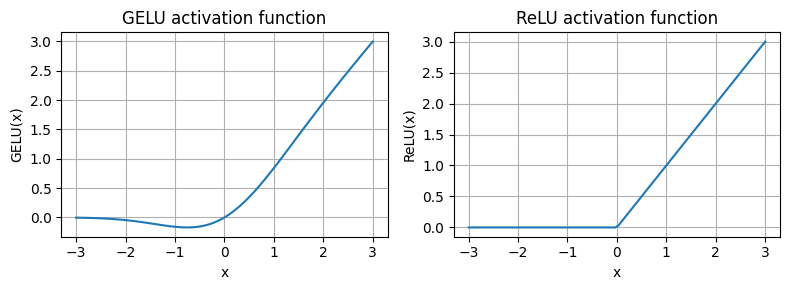

In [11]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()
#Creates 100 sample data points in the range –3 to 3
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()


The smoothness of GELU can lead to better optimization properties during training. In contrast, ReLU has a sharp corner at zero

Now lets use the GELU activation in a feed forward network (FFN) which is used in transformers.

as we see below, this ``FeedForward`` module plays a crucial role in enhancing the model’s ability to learn from and generalize the data. Although the input and output dimensions of this module are the same, it internally expands the embedding dimension into a higher- dimensional space through the first linear layer. This expansion, followed by a nonlinear GELU activation and then a contraction back to the original dimension with the second linear transformation allows exploration of richer dimension space.

In [12]:
import torch
import torch.nn as nn
class FeedForward(nn.Module):
    def __init__(self, cfg, hidden_layer_dim_factor = 4):
        super().__init__()
        emb_dim = cfg["emb_dim"]
        self.layers = nn.Sequential(
            nn.Linear(emb_dim, hidden_layer_dim_factor * emb_dim),
            GELU(),
            nn.Linear(hidden_layer_dim_factor * emb_dim, emb_dim)
        )

    def forward(self, in_batch):
        return self.layers(in_batch)

We will now look at the final part of the blocks, which is

### Adding the shortcut connections

Originally shortcut connections were introduced in ResNets to help with the vanishing gradient problem in very deep networks. They allow gradients to flow more easily through the network during backpropagation, making it easier to train deep models. In transformers, shortcut connections help preserve the original input information and improve gradient flow, which is crucial for training stability and performance.

Following image shows gow the shortcut connections create an alternative, shorter path for the gradient to flow through the networl by skipping one or more layers.
![test](./Shortcut.png)


Lets demonstrate this concept by implementing this ``ExampleDeepNeuralNetwork``

In [13]:
import torch
import torch.nn as nn
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[idx - 1], layer_sizes[idx]), GELU()) for idx in range(1, len(layer_sizes))
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            # The second condition ensures that we only add the shortcut when the dimensions match and not all layers
            x = x + layer_output if self.use_shortcut and x.shape == layer_output.shape else layer_output
        return x


Lets examine how the gradients flow through the network with and without shortcut connections. We will create two instances of the `ExampleDeepNeuralNetwork` class: one with shortcut connections enabled and another without them. We will then perform a forward pass followed by a backward pass to compute gradients, and finally, we will inspect the gradients of the input layer to see how they differ in both cases.

In [14]:
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])
    loss = nn.MSELoss()
    loss = loss(output, target)
    loss.backward()
    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152039906941354
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


As we see above how the gradients get smaller and smaller as we progress backward (layer 4 to layer 0) when we do not use shortcut connections, this is because of the vanishing gradient problem. Now lets see how the gradients look when we use shortcut connections.

In [15]:
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


As we see above the gradients are more stable and do not vanish when we use shortcut connections. This stability in gradients helps in better training of deep networks.

### Coding the attention and linear layers in a transformer block

Following is how the transformer block looks like, we will implement the missing pieces one by one.
![test](./Transformer.png)

Lets recap and (copy over) the MultiHeadAttention class we implemented in chapter 3.

In [20]:
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)
        # This is new, we will add an optional Linear layer to project the output.
        self.out_proj = nn.Linear(d_out, d_out)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in_ca = x.shape
        keys_mha = self.W_key(x)       # (b, num_tokens, d_out)
        values_mha = self.W_value(x)   # (b, num_tokens, d_out)
        queries_mha = self.W_query(x)  # (b, num_tokens, d_out)

        # d_out is same as num_heads * head_dim
        # view reshapes the tensor without changing its data, in this case we project the
        # last d_out dimension to (num_heads, head_dim)
        keys_mha = keys_mha.view(b, num_tokens, self.num_heads, self.head_dim) # (b, num_tokens, num_heads, head_dim)
        values_mha = values_mha.view(b, num_tokens, self.num_heads, self.head_dim) # (b, num_tokens, num_heads, head_dim)
        queries_mha = queries_mha.view(b, num_tokens, self.num_heads, self.head_dim) # (b, num_tokens, num_heads, head_dim)

        # To calculation the attention score, we need the last two dimensions to be num_tokens and head_dim
        # thus we need to transpose the 1st and 2nd dimensions
        queries_mha.transpose_(1, 2)  # (b, num_heads, num_tokens, head_dim)
        keys_mha.transpose_(1, 2)     # (b, num_heads, num_tokens, head_dim)
        values_mha.transpose_(1, 2)   # (b, num_heads, num_tokens, head_dim)

         # Let calculate the attention scores, this is the dot product of queries and keys
        attn_scores_mha = queries_mha @ keys_mha.transpose(-2, -1) # (b, num_heads, num_tokens, num_tokens)

        # Apply the mask, the dimensions of the attn scores are still (b, num_heads, num_tokens, num_tokens)
        #  the mask is 2D and is applied to the last two dimensions only
        attn_scores_mha.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf) #(b, num_heads, num_tokens, num_tokens)
        attn_weights_mha = torch.softmax(attn_scores_mha / self.head_dim ** 0.5, dim=-1) #(b, num_heads, num_tokens, num_tokens)
        # Apply dropout to the attention weights
        attn_weights_mha = self.dropout(attn_weights_mha) # (b, num_heads, num_tokens, num_tokens)
        # attn_weights_mha @ values_mha gives (b, num_heads, num_tokens, head_dim)
        # We need to transpose the 1st and 2nd (both 0 indexed) dimensions to get (b, num_tokens, num_heads, head_dim)
        context_vecs_mha = (attn_weights_mha @ values_mha).transpose(1,2) # (b, num_tokens, num_heads, head_dim)
        # We will reshape the context vectors back to (b, num_tokens, d_out) where d_out = num_heads * head_dim
        context_vecs_mha = context_vecs_mha.contiguous().view(b, num_tokens, self.d_out) # (b, num_tokens, d_out)
        # Finally we will project the output using the out_proj layer
        context_vecs_mha = self.out_proj(context_vecs_mha)
        return context_vecs_mha



In [23]:
class TransformerBlock(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            dropout=cfg["drop_rate"],
            num_heads=cfg["n_heads"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.dropout_shortcut = nn.Dropout(cfg["drop_rate"])
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.ff = FeedForward(cfg)

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.dropout_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.dropout_shortcut(x)
        x = x + shortcut
        return x

In [24]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


As we see above the input and output shapes are the same, which is expected as the transformer block does not change the dimensions of the input.


Next, we will code the entire GPT model using the `TransformerBlock` we just implemented.

### Coding the GPT model

Lets look at the final structure of the GPT Model we plan to build

![test](./FinalModel.png)

In [33]:
import torch
import torch.nn as nn
class GPTModel(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        return self.out_head(x)

Lets look at the GPT2 config once again

In [34]:
GPT_CONFIG_124M


{'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

In [35]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


Lets now look at how many parameters our model has


In [36]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


We see the above nmodel has 163M parameters where as GPT2 has 124M parameters. This is because our output linear layer has separate weights where we GPT2 uses a concept called Weight Tying to reduce the number of parameters. This means the token embedding layer and the output linear layer share the same weights.

Lets see how that math adds up

In [42]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [45]:
total_params_gpt2 = total_params - model.out_head.weight.numel()
print(f"Number of trainable parameters "
      f"considering weight tying: {total_params_gpt2:,}"
)

Number of trainable parameters considering weight tying: 124,412,160


What we see above matches the number of parameters in GPT2-124M model.

TODO: Ex 4.1

Lets calculate the memory requirements for training the model, assuming each paramater needs a 32 bit float32 we will need



In [46]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


TODO: Ex 4.2

### Generating Text

